In [41]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from CoolProp.CoolProp import PropsSI
from pint import UnitRegistry
u = UnitRegistry()
u.default_format = 'C'


# Options for pandas
#pd.options.display.max_columns = 50
#pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()
from IPython.display import display_latex

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
h = 8
w = h*1.61803398875
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)

#from matplotlib import rc
plt.rc('font',**{'family':'serif','serif':['Times New Roman']})
plt.rc('text', usetex=True)

# Publish
from ipypublish.scripts import nb_setup

In [55]:
def chem_prop(pressure, chemical, state):
    '''
    Returns the entropy, specific gravity, enthalpy, and internal energy of a specific chemical
    at saturation.
    '''
    s_g = PropsSI('S','P',pressure,'Q',1,chemical)/1000;
    s_f = PropsSI('S','P',pressure,'Q',0,chemical)/1000; 
    v_g = 1/PropsSI('D','P',pressure,'Q',1,chemical); 
    v_f = 1/PropsSI('D','P',pressure,'Q',0,chemical); 
    h_g = PropsSI('H','P',pressure,'Q',1,chemical); 
    h_f = PropsSI('H','P',pressure,'Q',0,chemical);
    u_g = (h_g - pressure*(v_g))/1000;
    u_f = (h_f - pressure*(v_f))/1000;
    return [chemical, state, pressure, s_g, s_f, v_g, v_f, h_g, h_f, u_g, u_f]

def build_state_table(state1,state2):
    '''
    Returns a dictionary of a chemical at two different states.
    '''
    data = {'State': [state1[0] + '-' + state1[1], state2[0] + '-' + state2[1]],
            '$P \\left(kPa\\right)$': [state1[2]/1000, state2[2]/1000],
            r'$u_f \left(\frac{kJ}{kg\:K}\right)$': [state1[10], state2[10]],
            r'$u_g \left(\frac{kJ}{kg\:K}\right)$': [state1[9], state2[9]],
            r'$v_f \left(\frac{m^3}{kg}\right)$': [state1[6], state2[6]],
            r'$v_g \left(\frac{m^3}{kg}\right)$': [state1[5], state2[5]],
            r'$s_f \left(\frac{kJ}{kg\:K}\right)$': [state1[4], state2[4]],
            r'$s_g \left(\frac{kJ}{kg\:K}\right)$': [state1[3], state2[3]],
            r'$h_f \left(\frac{kJ}{kg}\right)$': [state1[8]/1000, state2[8]/1000],
            r'$h_g \left(\frac{kJ}{kg}\right)$': [state1[7]/1000, state2[7]/1000]}
    return data

def ellipsoidal_head(diameter, thickness):
    '''
    Returns the volume (lb) of material in an ellispoidal head (2:1) given the
    diameter (arg1) and thickness (arg2).
    '''
    o_dia = diameter
    i_dia = diameter - 2*thickness
    ellipsoidal_head_outer = ((np.pi)*(o_dia**2)*(o_dia/4))/6
    ellipsoidal_head_inner = ((np.pi)*(i_dia**2)*(i_dia/4))/6
    volume_of_head = ellipsoidal_head_outer - ellipsoidal_head_inner
    return volume_of_head



def cylinder(length, diameter, thickness):
    '''
    Returns the volume of material in a cylinder given the length (arg1),
    diameter (arg2), thickness (arg3).
    '''
    o_dia = diameter
    i_dia = diameter - 2*thickness
    cylinder_outer = ((np.pi)*(o_dia**2)*(length))/4
    cylinder_inner = ((np.pi)*(i_dia**2)*(length))/4
    volume_of_cylinder = cylinder_outer - cylinder_inner
    return volume_of_cylinder

def print_ie(state,chemical,row):
    '''
    Prints the chemical (arg2) u = h - pv for each state (arg1) using the dataframe row (arg3)
    '''
    #chemical
    #1
    #fluid
    hf = df.iloc[row][7]
    uf = df.iloc[row][1]
    p = df.iloc[row][0]
    vf = df.iloc[row][3]
    #gas
    hg = df.iloc[row][8]
    ug = df.iloc[row][2]
    p = df.iloc[row][0]
    vg = df.iloc[row][4]
    #print
    print('Internal energy of liquid %s at state %s: %8.2f = %8.2f - (%8.2f)(%8.6f)' % (chemical,state,uf,hf,p,vf))
    print('Internal energy of gaseous %s at state %s: %8.2f = %8.2f - (%8.2f)(%8.6f)' % (chemical,state,ug,hg,p,vg))
    return

def quality(chem_state1, chem_state2):
    '''
    Returns the quality of the fluid at state 
    '''
    s_f1 = chem_state1[4]
    s_f2 = chem_state2[4]
    s_g1 = chem_state1[3]
    s_g2 = chem_state2[3]
    
    Xf2 = abs((s_f1 - s_f2))/abs((s_g2-s_f2))
    Xg2 = abs((s_g2 - s_g1))/abs((s_g2-s_f2))
    return Xf2, Xg2
    
def print_units(num_w_units):
    '''
    This function returns a formated str from a number with pint units.
    '''
    if num_w_units.magnitude < 0.1:
        value = print('{:~.3f}'.format(num_w_units))
    else:
        value = print('{:~.2f}'.format(num_w_units))
    return value

# Introduction
On June 21, 2019, at approximately 4:22 AM, a fire and explosion, see \cref{fig:fire}, occurred at the Girard Point Refinery owned by Philadelphia Energy Solutions \cite{Renshaw2019}.  One of the three explosions observed that day was from the V1 treater-feed-surge-drum in the refineries pretreatment unit.  The explosion propelled the largest piece (estimated: $41809.6lb\:(18964.5kg)$) of the drum approximately $2100ft\:(640m)$ from the blast seat, see \cref{fig:tank}.  It is hypothesized that a boiling-liquid expanding-vapor explosion (BLEVE) event provided the energy to generate the blast wave.  The Philadelphia Fire Department requested ATF estimate the blast overpressure generated when the tank exploded.  This paper is an engineering analysis to estimate the blast overpressure assuming a BLEVE occurred.  The analysis is based upon an adiabatic and isentropic energy analysis developed by the Center for Chemical Process Safety \cite{Safety2010}. 

![A view of the Philadelphia Energy Solutions Inc's oil refinery while on fire \cite{Maykuth2019}.](report_images/fig_refinery_fire.png){#fig:fire width=75% placement='H'}

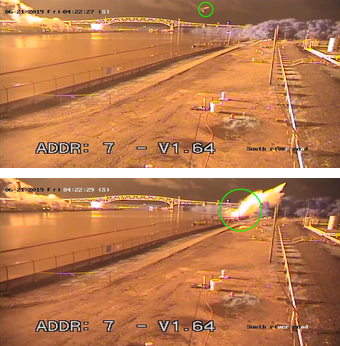

In [43]:
image1 = 'report_images/drum_in_flight.png'
image2 = 'report_images/drum_landing.png'
nb_setup.images_vconcat([image1, image2], width=340, gap=10)


# Background

## Refinery

The Girard Point Refinery is located in southwest Philadelphia, PA, on the Schuylkill River, see \cref{fig:map}.  The refinery produced approximately 335,000 bpd of gasoline, and was the largest on the East Coast \cite{AssociatedPress2019}.  The treater-feed-surge-drum, involved in the explosion, is part of the pretreatment process of alkylation used in the production of gasoline. 

![Map of Girard Point Refinery showing the blast seat location \cite{Duchneskie2019}.](report_images/fig_map_girard.jpeg){#fig:map width=75% placement='H'}

## Treater Feed Surge Tank

Alkylaition generally converts propylene $(C_3H_6)$, butylene $(C_4H_8)$, pentene $(C_5H_{10})$, and isobutane $(C_3H_{10})$ to alkane liquids such as isoheptane $(C_7H_{16})$ and isooctane $(C_8H_{16})$.  These alkylates are a highly valued component in the production of gasoline because of there high octane and low vapor pressure \cite{flowserve2000}.  The treater-feed-surge-drum (TFSD) was located between the fluid catalytic cracker and the alkylaition unit. The purpose of a surge drum is to stabilize fluctuations in the overall system flow rate.  The TFSD was part of the pretreatment process for alkylation, see \cref{fig:fig_process_flow}.  During pretreatment, also referred to as sweetening, sulfur compounds (hydrogen sulfide, thiophene and mercaptan) are removed to improve color, odor, and oxidation stability.

![Simple flow diagram of the sweetening and treating process where the TFSD was located at the time of the explosion. \cite{Temur2014,Malone2019}](report_images/fig_process_flow.jpeg){#fig:fig_process_flow width=75% placement='H'}

The TFSD tank measured 39'-8" in length, not including the heads, see \cref{tbl:tbl_tank} and \cref{fig:fig_tank} for construction details \cite{PES2019}. At the time of the explosion, the TFSD contained $20160gal\:(76.3m^3)$ of butane (50% by volume) and butene (40% by volume) and other lesser constituients, see \cref{tbl:tbl_chemicals_in_tank}.

Parameter             Value              Units
--------              --------           --------
Type                  horizontal         NA
Year Built            1972               NA
Construction Material A516 Type 70 Steel NA
Tank Wall Thickness   0.8125             in
Volume                372228             gal
Percent Filled        53.3               %
Mass                  74660              lb
Safety Valve Set      155                psig

Table: Treater-Feed-Surge-Drum Construction Parameters \cite{PES2019} {#tbl:tbl_tank align=rll widths=[0.25,0.25,0.25]}

![Diagram depicting the dimensions of the TFSD tank.  The tank was positioned 25 ft above ground level and estimated to contain 20160 gal (53.3% filled) of butane (50% by volume) and butene (40% by volume) at the time of the explosion.\cite{PES2019}](report_images/fig_tank.jpeg){#fig:fig_tank width=80% placement='H'}

Chemical  Percent by Volume
--------  --------
methane     0.01
ethylene    0.00
ethane      0.01
propane     0.90
propylene   0.10
isobutane  37.28
nbutane    12.81
butens     40.41
neopentane  0.00
isopentane  3.94
npentane    0.25
butadiene   0.33
benzene     0.00
C5 olefins  3.54
C6 sats     0.33
C7+         0.04

Table: Chemical Contents in the Treater-Feed-Surge-Drum Nearest to the Time of the Explosion \cite{PES2019} {#tbl:tbl_chemicals_in_tank align=rr widths=[0.2,0.2]}

For this analysis it will be assumed that the entire mixture is butane.  This assumption greatly simplifies the analysis, avoiding partial pressures and multiple energy calculations with different vapor qualities.  The assumption is reasonable because butane and butene make up more than 90% of the fluid volume and butane and butene are chemically similar, see \cref{tbl:tbl_butane_prop}.  The boiling temperatures for butene and butane are $20.66\: ^{\circ} F\:(-6.3\: ^{\circ} C)$ and $31.1\: ^{\circ} F\:(-1.0\: ^{\circ} C)$ respectively; both are well above the tank temperature when exposed to fire so a BLEVE assumptions is reasonable.






| Property                  | Butene      | Butane     |
|---------------------------|-------------|------------|
| Molecular Formula         | $C_4H_8$        | $C_4H_{10}$      |
| Molecular Weight          | $56.108\frac{g}{mol}$ | $58.12g\frac{g}{mol}$ |
| Boiling Point at 760mm Hg | $20.6^{\circ}F$ | $31.1^{\circ}F$     |
| Flash Point               | $-110.0^{\circ}F$ | $-76.0^{\circ}F$      |
| Density at 25$^{\circ} C$, 1 atm    | $0.588\frac{g}{cc}$  | $0.573\frac{g}{cc}$ |
| $\frac{C_P}{C_V}$ Ratio $\gamma$  |1.13    | 1.12                 |

Table: Chemical Properties of Butene and Butane \cite{PubChem-butane, PubChem-butene} {#tbl:tbl_butane_prop align=rrr widths=[0.3,0.3,0.3]}

## Pressure Relief Valve

The TFSD was fitted with a Consolidated (1906-30LC-1-CC-MS-31-RF-1) 3" x 4" pressure relief valve (PRV).  The relief pressure was set to $155 psig\:(1068.7kPa)$ and the relief temperature was set to $183.5^{\circ} F\:(84.3^{\circ}C)$.  The PRV was positioned on the top of the TRFD, see \cref{fig:fig_tank}.

## Recovered Drum Debris
Three major pieces of the TFSD were identified after the explosion.  They were thrown a maximum of $2100ft\:(640m)$, see \cref{fig:blast_debris}.  The largest piece (Large End Cap) was approximately $22ft\:(6.7m)$ in length, see \cref{fig:large_end_cap}, or a little more than half the original tank length.  The other end of the TFSD (Small End Cap) was recovered $1761ft\:(536m)$ from the blast seat.  It was approximately $5ft\:(1.5m)$ in length, see \cref{fig:small_end_cap}.  The piece thrown the shortest distance (fillet) was $819ft\:(249m)$ from the blast seat.  The fillet piece was heavily damaged and a photographic analysis of the length was not possible.  However, based on the original length of the tank and removing the large and small end cap lengths the fillet length is approximately $12ft\:(3.6m)$, see \cref{fig:fillet}.

![Map of Girard Point showing the blast seat and locations of the three main pieces of the TSFD (V-1).\cite{Malone2019a}](report_images/drum_debris_and_blast_seat_distances_small.png){#fig:blast_debris width=75% placement='H'}

![Photograph of the large end cap, estimated to be $22ft\:(6.7m)$ in length based on photographic analysis.  In this photograph the tank has been moved from it's original landing location.\cite{Malone2019a}](report_images/tank_length_estimate.png){#fig:large_end_cap width=75% placement='H'}

![Photograph of the small end cap, estimated to be $5ft\:(1.5m)$ in length based on photographic analysis.\cite{Malone2019a}](report_images/end_cap_03.jpg){#fig:small_end_cap width=75% placement='H'}

![Photograph of the fish fillet piece, calculated to be $12ft\:(3.6m)$ in length based on the total length of the drum less the lengths of the large and small end caps.\cite{Malone2019a}](report_images/1_fish_fillet2.jpg){#fig:fillet width=75% placement='H'}

The estimated mass of each piece of the TFSD is summarized in \cref{tbl:tbl_tank}.  The mass calculations are based on the refinery recorded mass of the vessel, $74660lb\:(33865kg)$, multiplied by the percent mass calculated using the following equations,

Ellipsoidal Head: $$V_{eh}=\frac{\pi D^2 (D/4)}{6}$$
Cylinder: $$V_c = \frac{\pi D^2 l}{4}$$

where the drum wall thickness is $0.83in\:(2.1cm)$, the tank diameter is $12ft\:(3.7m)$, and the material density for A516 steel is $7.8g/cc$\cite{Malone2019}.  The difference in calculated and refinery recorded mass is likely due to appurtenances attached to the tank not accounted for in the calculated mass.
 






TFSD ID               Cylinder (ft)      Calculated Debris Mass (lb)   Percent Mass Calculated         Refinery Recorded Mass (lb)  
--------              -------------      --------------------          -----------------------------   ---------------------
Large End Cap         22.0               31541.8                       0.56                            41809.6
Small End Cap          5.0               10078.5                       0.18                            13438.8
Fillet                12.0               15150.5                       0.26                            19411.6
Total                 39.0               56770.8                       1.00                            74660.0

Table: Estimated Treater-Feed-Surge-Drum Debris Mass \cite{PES2019} {#tbl:tbl_tank align=lrrrr widths=[0.2,0.1,0.1,0.15,0.15]}


## Boiling-Liquid Expanding-Vapor Explosion (BLEVE)

A BLEVE results from the sudden failure of a tank containing a compressed vapor (head space) and a super-heated liquid (a liquid heated above it's boiling point but without boiling). The magnitude of the blast depends on how super-heated the liquid was at failure.  As the level of super-heat rises, the portion of liquid that flash-boils rises, thus increasing the energy released.  Once containment failure occurs the energy is distributed into four forms:

1. Overpressure wave
2. Kinetic energy of fragments
3. Deformation and failure of the containment material
4. Heat transferred to environment

The distribution of the energy into the these four forms depends on the specifics of the explosion.  Planas-Cuchi et al. found that a *fragile* failure releases 80% of the energy into the blastwave, while a *ductile* failure releases 40% of the energy into the blastwave.  The remaining energy becomes kinetic energy of the fragments.  The heat transfer to the environment is relatively small \cite{Planas2004}.  In practice most pressure vessels are designed with materials that are ductile rather than brittle to avoid sudden and catastrophic brittle (fragile) failures \cite{Benac2016}.



In [44]:
# Large End Cap Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 22 * u.feet
den = 487 * u.lb/u.ft**3

hv = ellipsoidal_head(dia, thk)
cv = cylinder(lng, dia, thk)

wt_h = hv*den
wt_c = cv*den
wt_t = wt_c + wt_h
round(wt_t,3)
l_over_d = lng/dia

31541.808 <Unit('pound')>

In [45]:
# Small End Cap Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 5 * u.feet
den = 487 * u.lb/u.ft**3

hv = ellipsoidal_head(dia, thk)
cv = cylinder(lng, dia, thk)

wt_h = hv*den
wt_c = cv*den
wt_t = wt_c + wt_h
round(wt_t,3)

10078.562 <Unit('pound')>

In [46]:
# Fillet Weight
dia = 12 * u.feet
thk = 0.06916667 * u.feet
lng = 12 * u.feet
den = 487 * u.lb/u.ft**3

cv = cylinder(lng, dia, thk)

wt_c = cv*den

round(wt_c,3)

15150.527 <Unit('pound')>

In [150]:
p_relief = 155 * u.psi
p_relief = p_relief.to(u.Pa)
p_atm = 101325.0 * u.Pa
p_1 = 1.21*(p_relief + p_atm).to(u.Pa)
p_2  = p_atm; #
V_drum = 140.8197 * u.m**3
Pct_l = 0.533 # percent by volume of fluid in the tank
Pct_g = 1 - Pct_l # percent by volume of vapor in the tank
R = 25* u.ft
a0 = 340 * u.m / u.s
vol_l = V_drum * Pct_l
vol_g = V_drum * Pct_g
gnd = 1.0
frag = 0.4

print('P_relief = {:P.2f} ({:P.2f})'.format(p_relief.to(u.psi), p_relief.to(u.kPa)))
print('P_atm = {:P.2f} ({:P.2f})'.format(p_atm.to(u.psi), p_atm.to(u.kPa)))
print('P_1 = {:P.2f} ({:P.2f})'.format(p_1.to(u.psi), p_1.to(u.kPa)))
print('P_2 = {:P.2f} ({:P.2f})'.format(p_2.to(u.psi), p_2.to(u.kPa)))
print('V_drum = {:P.2f} ({:P.2f})'.format(V_drum, V_drum.to(u.gal)))
print('% liquid = {:.2f}'.format(Pct_f))
print('% vapor = {:.2f}'.format(Pct_g))
print('R = {:P.2f} ({:P.2f})'.format(R, R.to(u.m)))
print('a0 = {:P.2f} ({:P.2f})'.format(a0.to(u.ft / u.s), a0))
print('V_l = {:P.2f} ({:P.2f})'.format(vol_l, vol_l.to(u.gal)))
print('V_g = {:P.2f} ({:P.2f})'.format(vol_g, vol_g.to(u.gal)))

P_relief = 155.00 pound_force_per_square_inch (1068.69 kilopascal)
P_atm = 14.70 pound_force_per_square_inch (101.33 kilopascal)
P_1 = 205.33 pound_force_per_square_inch (1415.71 kilopascal)
P_2 = 14.70 pound_force_per_square_inch (101.33 kilopascal)
V_drum = 140.82 meter ** 3 (37200.63 gallon)
% liquid = 0.53
% vapor = 0.47
R = 25.00 foot (7.62 meter)
a0 = 1115.49 foot / second (340.00 meter / second)
V_l = 75.06 meter ** 3 (19827.94 gallon)
V_g = 65.76 meter ** 3 (17372.69 gallon)


In [48]:
#propane calculations for comparision example problem *** DELETE ***
p_relief_p = 15 * u.bar
p_relief_p = p_relief_p.to(u.Pa)
p_p = 1.21*(p_relief_p + p_atm).to(u.Pa)
propane_1 = chem_prop(p_p.magnitude,'Propane','1')
propane_2 = chem_prop(p_2.magnitude,'Propane','2')
propane_dict = build_state_table(propane_1,propane_2)

# Philadelphia Refinery Calculations
# Butane
butane_1 = chem_prop(p_1.magnitude,'butane','1')
butane_2 = chem_prop(p_2.magnitude,'butane','2')
butane_dict = build_state_table(butane_1,butane_2)

# Combine all calculations into a Pandas Dataframe
pd = nb_setup.setup_pandas(escape_latex=False)
df1 = pd.DataFrame(butane_dict)
df2 = pd.DataFrame(propane_dict)
df = pd.concat([df1, df2])
df.set_index('State', inplace=True)
pd.options.display.float_format = '{:.2E}'.format
df

,$P \left(kPa\right)$,$u_f \left(\frac{kJ}{kg\:K}\right)$,$u_g \left(\frac{kJ}{kg\:K}\right)$,$v_f \left(\frac{m^3}{kg}\right)$,$v_g \left(\frac{m^3}{kg}\right)$,$s_f \left(\frac{kJ}{kg\:K}\right)$,$s_g \left(\frac{kJ}{kg\:K}\right)$,$h_f \left(\frac{kJ}{kg}\right)$,$h_g \left(\frac{kJ}{kg}\right)$
State,,,,,,,,,
butane-1,1.42E+03,4.48E+02,6.78E+02,2.11E-03,2.77E-02,1.78E+00,2.49E+00,4.51E+02,7.17E+02
butane-2,1.01E+02,1.99E+02,5.47E+02,1.66E-03,3.69E-01,9.96E-01,2.41E+00,1.99E+02,5.85E+02
Propane-1,1.94E+03,3.50E+02,5.82E+02,2.29E-03,2.25E-02,1.50E+00,2.33E+00,3.55E+02,6.25E+02
Propane-2,1.01E+02,1.00E+02,4.84E+02,1.72E-03,4.14E-01,6.07E-01,2.45E+00,1.00E+02,5.26E+02


In [63]:
print_ie('1','butane',0)
print_ie('2','butane',1)
print_ie('1','propane',2)
print_ie('2','propane',3)

Internal energy of liquid butane at state 1:   448.47 =   451.46 - ( 1415.71)(0.002110)
Internal energy of gaseous butane at state 1:   677.77 =   716.93 - ( 1415.71)(0.027658)
Internal energy of liquid butane at state 2:   198.70 =   198.87 - (  101.33)(0.001663)
Internal energy of gaseous butane at state 2:   547.18 =   584.58 - (  101.33)(0.369098)
Internal energy of liquid propane at state 1:   350.15 =   354.58 - ( 1937.60)(0.002287)
Internal energy of gaseous propane at state 1:   581.68 =   625.20 - ( 1937.60)(0.022459)
Internal energy of liquid propane at state 2:   100.18 =   100.36 - (  101.33)(0.001722)
Internal energy of gaseous propane at state 2:   484.01 =   525.95 - (  101.33)(0.413884)


# Calculation of Air Blast from a BLEVE
There is a seven step process for calculating the air blast from a BLEVE:

1.  Data Collection
    1.  Vessel internal pressure, $p_1$
    1.  Ambient air pressure, $p_2$
    1.  Vessel volume
    1.  Ratio of specific heats of gas in the vessel
    1.  Distance from the center of the tank to the receptor
    1.  Shape of the vessel (spherical or cylindrical)
    1.  Speed of sound of air
    1.  Ratio of specific heats of air  
2.  Calculate the Internal Energy at the Initial State (pre-explosion)
2.  Calculate the Internal Energy at the Final State (atmospheric)
2.  Calculate the Specific Work
2.  Calculate the Explosion Energy
2.  Calculate the Non-Dimensional Range to the Receptor
7.  Calculate Overpressure and Impulse

## Data Collection
For this analysis the following data will be used:

1.  Ambient air pressure, {{p_atm_s}}
2.  Vessel volume, {{v_tank_s}}
3.  Ratio of specific heats of butane (1.12)
4.  Distance from the center of the tank to the receptor, {{R_s}}
5.  Shape of the vessel is cylindrical, L/D={{l_over_d_s}}
6.  Speed of sound of air, {{a_s}}

## Calculate the Internal Energy

### Pressure at State 1 (Pre-failure State)
The drum (tank) is assumed to fail at $1.21$ times the opening pressure of the pressure relief valve (PRV)\cite{Engineers2013}.  This pressure is based on the American Petroleum Institutes Standard 521 which, requires that pressure relief valves on pressure vessels achieve rated flow at 1.21 times the maximum allowable working pressure.  The PRV was set to {{p_relief_s}} therefore, the absolute pressure at state 1 (failure state) is given by,

$$p_1 = 1.21\left(p_{PRV}+p_{atm}\right)$$
$$p_1 = 1.21\left(14.70+155.00\right)$$
$$p_1 = 205.33 psia\:(1.42\:MPa)$$

### Pressure at State 2 (Final Expanded State)
The pressure at state 2 (final expanded state) is standard atmospheric pressure or {{p_atm_s}}.
### Internal Energy
Th internal energy $u$ can be used to estimate the energy released in an explosion.  With the gases in the saturated state and knowing the pressures at state 1 (explosion) and state 2 (atmospheric) we can use lookup tables determine the specific volume $v$, and the enthalpy $h$.  Combining these two properties with the pressure we can calculate the internal energy $u$ using,

$$h = u + pv$$

where $h$ is the enthalpy, $p$ is the pressure, and $v$ is the specific volume.  Therefore, solving for the internal energy $u$ we have,

$$u = h - pv$$
#### Internal Energy at State 1
The internal energy at at state 1 for saturated liquid butane is,

$$u_{1f-butane} = h_{1f-butane} - (p_{1-butane})(v_{1f-butane})$$
$$u_{1f-butane} = 451.46\:kJ/kg - (1415.72\:kPa)(0.002110\:m^3/kg)$$
$$u_{1f-butane} = 448.47\:kJ/kg$$

and for the saturated vapor butane at state 1 we have,

$$u_{1g-butane} = h_{1g-butane} - (p_{1-butane})(v_{1g-butane})$$
$$u_{1g-butane} = 716.93\:kJ/kg - (1415.72\:kPa)(0.027658\:m^3/kg)$$
$$u_{1g-butane} = 677.77\:kJ/kg$$

and similarly for saturated liquid and vapor butane at state 2,

$$u_{2f-butane} = 198.70\:kJ/kg$$
$$u_{2g-butane} = 547.18\:kJ/kg$$

All the gas properties are summarized in \cref{tbl:thermo}

In [142]:
Xf2p, Xg2p = quality(propane_1, propane_2)
Xf2b, Xg2b = quality(butane_1, butane_2)

print('X_f2p = %1.3f' % Xf2p)
print('X_g2p = %1.3f' % Xg2p)
print('X_f2b = %1.3f' % Xf2b)
print('X_g2b = %1.3f' % Xg2b)

X_f2p = 0.486
X_g2p = 0.067
X_f2b = 0.552
X_g2b = 0.060


In [143]:
s_f1b = butane_1[4]
s_f2b = butane_2[4]
s_g1b = butane_1[3]
s_g2b = butane_2[3]

print('s_1fb = %1.3f' % s_f1b)
print('s_2fb = %1.3f' % s_f2b)
print('s_1gb = %1.3f' % s_g1b)
print('s_2gb = %1.3f' % s_g2b)

s_1fb = 1.776
s_2fb = 0.996
s_1gb = 2.495
s_2gb = 2.410


In [144]:
u_f2b = butane_2[10]
u_g2b = butane_2[9]
print('u_f2b = %1.3f' % u_f2b)
print('u_g2b = %1.3f' % u_g2b)

u_f2xb = (1-Xf2b)*u_f2b + (Xf2b)*(u_g2b)
u_g2xb = (1-Xg2b)*u_g2b + (Xg2b)*(u_f2b)
print('u_f1xb = %1.3f' % u_f2xb)
print('u_g2xb = %1.3f' % u_g2xb)

u_f2b = 198.697
u_g2b = 547.176
u_f1xb = 390.890
u_g2xb = 526.398


In [145]:
u_f2p = propane_2[10]
u_g2p = propane_2[9]
print('u_f2p = %1.3f' % u_f2p)
print('u_g2p = %1.3f' % u_g2p)

u_f2xp = (1-Xf2p)*u_f2p + (Xf2p)*(u_g2p)
u_g2xp = (1-Xg2p)*u_g2p + (Xg2p)*(u_f2p)
print('u_f1xp = %1.3f' % u_f2xb)
print('u_g2xp = %1.3f' % u_g2xb)

u_f2p = 100.182
u_g2p = 484.011
u_f1xp = 390.890
u_g2xp = 526.398


In [146]:
u_f1p = propane_1[10]
u_exfp = u_f1p - u_f2xp
print('u_exfp = %1.3f' % u_exfp)

u_exfp = 63.246


In [147]:
u_g1p = propane_1[9]
u_exgp = u_g1p - u_g2xp
print('u_exgp = %1.3f' % u_exgp)

u_exgp = 123.336


In [148]:
u_f1b = butane_1[10]
u_exfb = u_f1b - u_f2xb
print('u_exfb = %1.3f' % u_exfb)

u_exfb = 57.578


In [149]:
u_g1b = butane_1[9]
u_exgb = u_g1b - u_g2xb
print('u_exgb = %1.3f' % u_exgb)

u_exgb = 151.375


#### Internal Energy at State 2
When the drum containment fails and the butane at state 1 expands to state 2 (atmospheric pressure) it is no longer at a saturated stated.  Some of the liquid vaporizes and some of the vapor condenses. We can use the quality of the vapor and liquid to calculate the unsaturated internal energy at state 2.  The vapor quality $(\chi)$, can be calculated from,

$$\chi = \frac{s_1 - s_2}{s_{g2}-s_{f2}}$$

where $s_1$ and $s_2$ are the entropies at the initial state (1) and $s_{g2}$ and $s_{f2}$ are the entropies of the final state (2) of the saturated vapor and fluid respectively.  If calculating the quality of the saturated *liquid* then $s_1=s_{f1}$ and $s_2=s_{f2}$ where $s_{f1}$ and $s_{f2}$ are the entropies at the initial (1) and final (2) states of the saturated fluid.  Similarly, if calculating the quality of the saturated *vapor* $s_1=s_{g1}$ and $s_2 = s_{g2}$ where $s_{g1}$ and $s_{g2}$ are the entropies at the initial (1) and final (2) states of the saturated vapor.  Therefore for saturated liquid butane we have,

$$\chi_f = \frac{s_{f1} - s_{f2}}{s_{g2}-s_{f2}}$$

$$\chi_f = \frac{1.775 - 0.996}{2.411-0.996}$$

$$\chi_f = 0.552$$

and for the saturated vapor,

$$\chi_g = \frac{s_{g1} - s_{g2}}{s_{g2}-s_{f2}}$$

$$\chi_g= \frac{2.495 - 2.410}{2.410-0.996}$$

$$\chi_g = 0.060$$

We can then calculate the unsaturated internal energy at state 2 using,

$$u_{2-fluid} = (1-\chi_f)u_{f2} + \chi_f u_{g2}$$
$$u_{2-vapor} = (1-\chi_g)u_{g2} + \chi_g u_{f2}$$

$$u_{2-fluid} = (1-0.552)198.70 + (0.552)(547.18)$$
$$u_{2-vapor} = (1-0.060)547.18 + (0.060)(198.70)$$

$$u_{2-fluid} = 390.89\:kJ/kg$$
$$u_{2-vapor} = 526.40\:kJ/kg$$

In [ ]:
m_f1 = Pct_f*V_1/v_f1 # mass of fluid at state 1 (kg)
m_g1 = Pct_g*V_1/v_g1 # mass of gas at state 1 (kg)
print("The mass of the fluid at state 1 is %8.2f kg" % (m_f1))
print("The mass of the vapor at state 1 is %8.2f kg" % (m_g1))
E_exf = 2*e_exf*m_f1 # explosion energy of fluid on the ground (factor of 2) at state 1 (kJ)
E_exg = 2*e_exg*m_g1 # explosion energy of gas on the ground at state 1 (kJ)
print("The explosion energy of the fluid at state 1 is %8.2f kJ." % (E_exf))
print("The explosion energy of the vapor at state 1 is %8.2f kJ." % (E_exg))
E_extot = E_exf+E_exg # total explosion energy on the ground at state 1
print("The total energy of the surface explosion is Ex_tot = %8.2f kJ." % (E_extot))

## Calculate the Specific Work
The specific work done by a BLEVE is the difference in internal energies at state 1 and state 2,
$$e_{ex}=u_1-u_2$$
For the saturated liquid butane we have,
$$e_{ex-fluid} = u_{1-fluid} - u_{2-fluid}$$
$$e_{ex-fluid} = 448.47\:kJ/kg - 390.89\:kJ/kg$$
$$e_{ex-fluid} = 57.58\:kJ/kg$$
For the saturated vapor butane we have,
$$e_{ex-vapor} = u_{1-vapor} - u_{2-vapor}$$
$$e_{ex-vapor} = 677.77\:kJ/kg - 526.40\:kJ/kg$$
$$e_{ex-vapor} = 151.38\:kJ/kg$$

In [ ]:
E_ex_v = frag*gnd*u_exgb*(V_drum/

## Calculate the Explosion Energy
The explosion energy is simply the specific work multiplied by the mass of fluid (liquid or vapor) initially in the drum.

$$E_{ex}=e_{ex}m$$

Where $e_{ex}$ is the specific work of the fluid (vapor or liquid) and $m$ is the mass of the fluid (vapor or liquid).

However, there are two additional factors that must be considered when estimating the explosion energy.  The first is the ground reflection factor, $gnd$. If the tank were on the ground the reflection factor is $gnd=2$.  However, the TFSD drum was located {{R_s}} above ground level.  For this case, a reflection factor of $gnd=1$ will be assumed.  The second factor is estimating the amount of energy lost in fragmenting the tank, $frag$.  This reduction in energy can range from $frag = 20\%$-$50\%$ \cite{Safety2010}.  For this calculation a fragmentation factor of $frag=40\%$ will be assumed.  With these additional factors our explosion energy is,

$$E_{ex}=(gnd)(frag)e_{ex}m$$
$$E_{ex}=(1)(0.4)e_{ex}m$$
$$E_{ex}=0.4e_{ex}m$$

Because the fluid is present both as a saturated vapor and liquid we will need to calculate the explosion energy for each and then sum them together.  For the saturated liquid butane we have,



In [ ]:
R_bar = R*(101325/1156.1e6)**(1/3)
print("The non-dimensional range of the receptor is %8.2f" % (R_bar))
print("The non-dimensional tank pressure p/po is %8.2f" % (p_1/p_atm))

In [ ]:
pr5 = pd.read_csv('bleve_overpressure_curves/p1_p0_5.csv'); pr5['z'] = r'$p/p_0=5.0$'; pr5['w'] = 5.0
pr10 = pd.read_csv('bleve_overpressure_curves/p1_p0_10.csv'); pr10['z'] = r'$p/p_0=10.0$'; pr10['w'] = 10.0
pr20 = pd.read_csv('bleve_overpressure_curves/p1_p0_20.csv'); pr20['z'] = r'$p/p_0=20.0$'; pr20['w'] = 20.0
pr50 = pd.read_csv('bleve_overpressure_curves/p1_p0_50.csv'); pr50['z'] = r'$p/p_0=50.0$'; pr50['w'] = 50.0
pr100 = pd.read_csv('bleve_overpressure_curves/p1_p0_100.csv'); pr100['z'] = r'$p/p_0=100.0$'; pr100['w'] = 100.0
pr200 = pd.read_csv('bleve_overpressure_curves/p1_p0_200.csv'); pr200['z'] = r'$p/p_0=200.0$'; pr200['w'] = 200.0
pr500 = pd.read_csv('bleve_overpressure_curves/p1_p0_500.csv'); pr500['z'] = r'$p/p_0=500.0$'; pr500['w'] = 500.0
pr1000 = pd.read_csv('bleve_overpressure_curves/p1_p0_1000.csv'); pr1000['z'] = r'$p/p_0=1000.0$'; pr1000['w'] = 1000.0
frame = [pr5, pr10, pr20, pr50, pr100, pr200, pr500, pr1000]
df_pr = pd.concat(frame, sort=True)
df_pr.head()

In [ ]:
#on a grid in [2, 18]x[0, 10] which was the axes of the
#original paper. The imaginary numbers 200j will break
#the grid into 200 equal spaces.

grid_x, grid_y = np.mgrid[0:10:200j, 0:1000:200j]

#we know the x,y,z values from the original plot image 

points = df_pr[['R','P']].values
values = df_pr['w'].values

points_df_pr = df_pr[['R','w']].values
values_df_pr = df_pr['P'].values

#The cubic method of griddata was used for interpolation.  Grid_x and Grid_y
#can be either a matrix of points or a single pair.
grid_z2_pr = griddata(points_df, values_df, (grid_x, grid_y), method='cubic')

sd_p_vert = 20
sd_r_horz = 4.4
pr = griddata(points_df_pr, values_df_pr, (sd_r_horz, sd_p_vert), method='cubic')
print("The non-dimensional incident overpressure is %8.3f" % (pr))

In [ ]:
# Get an empty figure
fig1 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig1.add_subplot(1,1,1)

# Generate the plot
grpd = df_pr.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_pr[df_pr.z==name].R.values, df_pr[df_pr.z==name].P.values, label = name);
plt.plot(sd_r_horz,pr,'rp', label = '$Nondimensional\:Overpressure$');
plt.legend();
plt.axhline(y=pr, color='r', linestyle='-')
plt.axvline(x=sd_r_horz, color='r', linestyle='-')
#plt.text(sd_r_horz, pv/2, '$\left({{{}}},{{{}}}\right)$'.format([sd_r_horz,pv]), ha='right', va='center')

# Set labels for x and y axis
ax.set_xlabel('$R/(E/p_0)^{1/3}$');
ax.set_ylabel('$(P-p_0)/p_0$');
ax.grid(True, which='both')

# Display the figure
plt.show();

In [ ]:
ir5 = pd.read_csv('bleve_impulse_curves/ip1_p0_5.csv'); ir5['z'] = r'$p/p_0=5.0$'; ir5['w'] = 5.0
ir10 = pd.read_csv('bleve_impulse_curves/ip1_p0_10.csv'); ir10['z'] = r'$p/p_0=10.0$'; ir10['w'] = 10.0
ir20 = pd.read_csv('bleve_impulse_curves/ip1_p0_20.csv'); ir20['z'] = r'$p/p_0=20.0$'; ir20['w'] = 20.0
ir50 = pd.read_csv('bleve_impulse_curves/ip1_p0_50.csv'); ir50['z'] = r'$p/p_0=50.0$'; ir50['w'] = 50.0
ir100 = pd.read_csv('bleve_impulse_curves/ip1_p0_100.csv'); ir100['z'] = r'$p/p_0=100.0$'; ir100['w'] = 100.0
ir200 = pd.read_csv('bleve_impulse_curves/ip1_p0_200.csv'); ir200['z'] = r'$p/p_0=200.0$'; ir200['w'] = 200.0
ir500 = pd.read_csv('bleve_impulse_curves/ip1_p0_500.csv'); ir500['z'] = r'$p/p_0=500.0$'; ir500['w'] = 500.0
ir1000 = pd.read_csv('bleve_impulse_curves/ip1_p0_1000.csv'); ir1000['z'] = r'$p/p_0=1000.0$'; ir1000['w'] = 1000.0
frame = [ir5, ir10, ir20, ir50, ir100, ir200, ir500, ir1000]
df_ir = pd.concat(frame, sort=True)
df_ir.head()

In [ ]:
#on a grid in [2, 18]x[0, 10] which was the axes of the
#original paper. The imaginary numbers 200j will break
#the grid into 200 equal spaces.

grid_x, grid_y = np.mgrid[0:10:200j, 0:1000:200j]

#we know the x,y,z values from the original plot image 

points = df_ir[['R','I']].values
values = df_ir['w'].values

points_df_ir = df_ir[['R','w']].values
values_df_ir = df_ir['I'].values

#The cubic method of griddata was used for interpolation.  Grid_x and Grid_y
#can be either a matrix of points or a single pair.
grid_z2_ir = griddata(points_df_ir, values_df_ir, (grid_x, grid_y), method='cubic')

sd_p_vert = 20
sd_r_horz = 4.4
ir = griddata(points_df_ir, values_df_ir, (sd_r_horz, sd_p_vert), method='cubic')
print("The non-dimensional incident impulse is %8.3f" % (ir))

In [ ]:
# Get an empty figure
fig2 = plt.figure(figsize = [w,h])

# Get the axes instance at 1st location in 1x1 grid
ax = fig2.add_subplot(1,1,1)

# Generate the plot
grpd = df_ir.groupby('w').apply(lambda x: x.sort_values('z')) # Group by 'w' then sort by 'z'
for name in grpd['z'].unique(): # Iterate through grouped values of z and plot
    plt.loglog(df_ir[df_ir.z==name].R.values, df_ir[df_ir.z==name].I.values, label = name);
plt.plot(sd_r_horz,ir,'rp', label = '$Nondimensional\:Overpressure$');
plt.legend();
plt.axhline(y=ir, color='r', linestyle='-')
plt.axvline(x=sd_r_horz, color='r', linestyle='-')

# Set labels for x and y axis
ax.set_xlabel('$R/(E/p_0)^{1/3}$');
ax.set_ylabel('$i\:a_0/(E^{1/3}p_0^{2/3})$');
ax.grid(True, which='both')

# Display the figure
plt.show();

In [ ]:
p_incident = pr*p_atm
print("The incident overpressure is %8.2f Pa (%8.2f psi)" % (p_incident, p_incident*0.000145038))

In [ ]:
i_s = (ir*((p_atm)**(2/3))*(E_extot*1000)**(1/3))/a0
print("The incident impulse is %8.2f Pa-s (%8.2f psi-s)" % (i_s, i_s*0.000145038))

## Nondimensional Side-on Pressure and Impulse
The nondimenstional side-on pressure can be calculated from Figure X and gives a $\bar{P_s} = 0.064$ for an $\bar{R}=4.4$ and a $p/p_0 = 19.12$.  The nondimensional side-on impulse can be calculated from Figure Y and gives a $\bar{i_s} = 0.013$ for an $\bar{R}=4.4$ and a $p/p_0 = 19.12$.

The side-on pressure and impulse can be calculated from the following:

$$\bar{P_s} - p_0 = (0.064)(101.325\:kPa) = 6.5\:kPa$$
$$i_s = \frac{(0.013)(101325\:kPa)^{2/3}(1160.9E6\:J)^{1/3}}{340\:m/s}= 86.31\:Pa {\text -} s$$
      